# Análise de Mídias Sociais: Twitter

Para autenticar no twitter, temos que criar uma conta e accessar: <br />
http://twitter.com/apps/new <br />
Gerar as chaves de autenticação, ex:<br />
CONSUMER_KEY = 'DcPtlOYZ07jilc3PgYJLUPdfdfdRjJXXXXX' <br />
CONSUMER_SECRET = 'bREXzcIMNLKhRpOhQGFuEKTaJhRhHcdfdfdjD3dKBe682Yt2MOiNv6bXXXX' <br />
OAUTH_TOKEN = '2904474861-coE0I5LEq8btCC0A18IPjqOp1G24dfdfdfvBgwXKyPi5bXXXX' <br />
OAUTH_TOKEN_SECRET = 'ppDRYIeSXOb6J6qajqXolniwVNgbAkIEdfdfdfYDS9VfIzOboQoXXXX'<br />

## Modulo para autenticação no twitter

In [2]:
!ls *.txt

dados.txt               tokens.txt
stopwords-portugues.txt tokes.txt


In [1]:
!pip install -q twitter
!pip install -q pymongo

In [3]:
!cat tokens.txt

DcPtlOYZ07jilc3PgYJLUPRjJ
bREXzcIMNLKhRpOhQGFuEKTaJhRhHcjD3dKBe682Yt2MOiNv6b
2904474861-qPmMjcwisBQWR1cMILoXevC8QeKS3Go3PzN5lBq
h0iaWqpk7YqsP9MAk5mU472ZOsFOtunfL76fwhEY3x9PA

## Leitura das chaves de acesso

In [4]:
def ler_tokens_acesso():
    filename = 'tokens.txt'
    with open(filename) as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content] 
    
    return content[0], content[1], content[2], content[3]

#CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET = ler_tokens_acesso()
#print(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

# Twitter

In [5]:
import twitter

def oauth_login():
    # XXX: Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    
    #CONSUMER_KEY = 'DcPtlOYZ07jilc3PgYJLUdfdfdfJ'
    #CONSUMER_SECRET = 'bREXzcIMNLKhRpOhQGFuEKTaJhRhHcjD3dKBe682Yt2MOdfdf'
    
    #OAUTH_TOKEN = '2904474861-hJHuW0Q1TGSUjOFvlgqU4ZFYvPCDO214aILxR5L'
   # OAUTH_TOKEN_SECRET = 'aBCJrbhXVEBgZ7gKo9yCNUMjlierefMkY43rZEvXK9BFI'
    
    CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET = ler_tokens_acesso()
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

# Sample usage
twitter_api = oauth_login()    

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print (twitter_api)

## Módulo para buscar tweets, dado uma palavra

In [6]:
def twitter_search(twitter_api, q, max_results=1000, **kw):  #max_results=200

    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets and 
    # https://dev.twitter.com/docs/using-search for details on advanced 
    # search criteria that may be useful for keyword arguments
    
    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets    
    search_results = twitter_api.search.tweets(q=q, count=1000, **kw)   # count=100
    
    statuses = search_results['statuses']
    
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://dev.twitter.com/docs/rate-limiting/1.1/limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

## Salvando/Recuperando no MongoDB

In [ ]:
#!pip install -q pymongo

In [7]:
import json
import pymongo # pip install pymongo


def save_to_mongo(data, mongo_db, mongo_db_coll, **mongo_conn_kw):
    
    # Connects to the MongoDB server running on 
    # localhost:27017 by default
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    
    # Get a reference to a particular database
    
    db = client[mongo_db]
    
    # Reference a particular collection in the database
    
    coll = db[mongo_db_coll]
    
    # Perform a bulk insert and  return the IDs
    
    return coll.insert_many(data)

def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False,
                    criteria=None, projection=None, **mongo_conn_kw):
    
    # Optionally, use criteria and projection to limit the data that is 
    # returned as documented in 
    # http://docs.mongodb.org/manual/reference/method/db.collection.find/
    
    # Consider leveraging MongoDB's aggregations framework for more 
    # sophisticated queries.
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    db = client[mongo_db]
    coll = db[mongo_db_coll]
    
    if criteria is None:
        criteria = {}
    
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)

    # Returning a cursor is recommended for large amounts of data
    
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]

## Capturando tweets

In [8]:
%%time

q = ''
q = ''
q = 'furacao ian'
q = 'terremoto equador'
result = twitter_search(twitter_api, q, max_results=5000)
type(result)

CPU times: user 88.8 ms, sys: 26.6 ms, total: 115 ms
Wall time: 7.59 s


list

In [9]:
result[4]

{'created_at': 'Mon Mar 20 18:34:52 +0000 2023',
 'id': 1637885433513144320,
 'id_str': '1637885433513144320',
 'text': 'RT @SpaceToday1: Terremoto de magnitude 6.7 atingiu hoje o Equador, muita destruição em algumas cidades, e até o momento 3 mortes relatadas…',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'SpaceToday1',
    'name': 'Sacani (Space Today)',
    'id': 338335282,
    'id_str': '338335282',
    'indices': [3, 15]}],
  'urls': []},
 'metadata': {'iso_language_code': 'pt', 'result_type': 'recent'},
 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 18059739,
  'id_str': '18059739',
  'name': 'João Luiz O!',
  'screen_name': 'jluizsc',
  'location': 'Criciuma SC Brasil',
  'description': ':p',
  'url': '

In [10]:
len(result)

200

In [12]:
#results = twitter_search(twitter_api, q, max_results=1000)
save_to_mongo(result, 'tweets2023', q)

In [13]:
%%time

q = ''
q = 'terremoto equador'
twitter_api = oauth_login()
results = []
for i in range(2):
    result = twitter_search(twitter_api, q, max_results=1000)
    print ('capturando ', len(result),' tweets...')
    results.extend(result) # junçao de 2 lstas
print("Numero de tweets capturados: ", len(results))

results = twitter_search(twitter_api, q, max_results=1000)
save_to_mongo(results, 'tweets', q)

capturando  200  tweets...
capturando  200  tweets...
Numero de tweets capturados:  400
CPU times: user 297 ms, sys: 48.4 ms, total: 345 ms
Wall time: 16.7 s


In [14]:
results[0] 

{'created_at': 'Mon Mar 20 21:12:37 +0000 2023',
 'id': 1637925133435166725,
 'id_str': '1637925133435166725',
 'text': 'Terremoto sísmico do Equador causou 14 mortos e 446 feridos, epicentro do terremoto foi em Balao, cidade que fica a… https://t.co/Hg3B7k0mrd',
 'truncated': True,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [{'url': 'https://t.co/Hg3B7k0mrd',
    'expanded_url': 'https://twitter.com/i/web/status/1637925133435166725',
    'display_url': 'twitter.com/i/web/status/1…',
    'indices': [117, 140]}]},
 'metadata': {'iso_language_code': 'pt', 'result_type': 'recent'},
 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1362505213299613700,
  'id_str': '1362505213299613700',
  'name': 'Mapasegeografia',
  'screen_name': 'mapase

In [15]:
results[2]['created_at']

'Mon Mar 20 19:53:37 +0000 2023'

In [16]:
results[2]['metadata']['iso_language_code']

'pt'

In [17]:
len(results)

200

## imprimindo tweets

In [18]:
#result = results
i = 0
for tweet in result:
    #print(tweet['place'], tweet['created_at'], ' >> ', tweet['text'] , " >> ", )
    print(tweet['text'])
    i += 1
    if i > 10:
          break

Terremoto sísmico do Equador causou 14 mortos e 446 feridos, epicentro do terremoto foi em Balao, cidade que fica a… https://t.co/Hg3B7k0mrd
RT @juliovschneider: Forte terremoto atinge Equador e mata ao menos 12 pessoas

O número de mortos pelo terremoto de magnitude 6,5 na escal…
Museu é invadido pela água após terremoto no Equador. 5 mil peças foram submersas após o tremor. #BandJornalismo https://t.co/GAypEZXoCO
Terremoto no Equador 6.9😱 https://t.co/W542R8nrRT
RT @SpaceToday1: Terremoto de magnitude 6.7 atingiu hoje o Equador, muita destruição em algumas cidades, e até o momento 3 mortes relatadas…
RT @Ishabakshi04: É moto no Equador aumentou de 4.7 para 6.9 vamos aguardar #terremoto https://t.co/t7apeE88pp
Um forte terremoto de magnitude 6,5 atingiu o sul do Equador, atingindo também o Peru, e deixou pelo menos quatro p… https://t.co/WeqzbDkHKi
RT @VanLiberdade: Terremoto no Equador 😱😱😰😰

Mudanças climáticas ou O ser Humano brincando de ser Deus? https://t.co/To4O8CuhYK
É moto no 

## Nuvem de Palavras - tweet

### Stopwords

In [19]:
# instalando o módulo de stopwords
!pip install -q stop-words
results = result

In [20]:
from stop_words import get_stop_words

stop_words_portugues = get_stop_words('pt')
print(stop_words_portugues)

['a', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'essa', 'essas', 'esse', 'esses', 'esta', 'estamos', 'estas', 'estava', 'estavam', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéramos', 'estivéssemos', 'estou', 'está', 'estávamos', 'estão', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'forem', 'formos', 'fosse', 'fossem', 'fui', 'fôramos', 'fôssemos', 'haja', 'hajam', 'hajamos', 'havemos', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houveram', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houvermos', 'houverá', 'houverão', 'houveríamos', 'houvesse', 'houvessem', 'houvéramos', 'houvéssemos', 'há', 'hão', 'isso', 'isto', 'já', 'lhe', 'lhes', '

In [21]:
from stop_words import get_stop_words
stop_words_english = get_stop_words('en')

#stop_words_portugues
stop_words_portugues = get_stop_words('pt')


#stop_words
stop_words = stop_words_english + stop_words_portugues

print(stop_words[:10])
print(stop_words[-10:])
print(len(stop_words_english))
print(len(stop_words_portugues))

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']
['tém', 'tínhamos', 'um', 'uma', 'você', 'vocês', 'vos', 'à', 'às', 'éramos']
174
203


In [22]:
#!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 2.5 MB/s eta 0:00:004.1 MB/s eta 0:00:01


In [23]:
type(result)

list

In [24]:
result[5]

{'created_at': 'Mon Mar 20 18:31:56 +0000 2023',
 'id': 1637884696993341447,
 'id_str': '1637884696993341447',
 'text': 'RT @Ishabakshi04: É moto no Equador aumentou de 4.7 para 6.9 vamos aguardar #terremoto https://t.co/t7apeE88pp',
 'truncated': False,
 'entities': {'hashtags': [{'text': 'terremoto', 'indices': [76, 86]}],
  'symbols': [],
  'user_mentions': [{'screen_name': 'Ishabakshi04',
    'name': 'isha bakshi🇧🇷🇧🇷🌏',
    'id': 1455551813940301826,
    'id_str': '1455551813940301826',
    'indices': [3, 16]}],
  'urls': [],
  'media': [{'id': 1637877279698067463,
    'id_str': '1637877279698067463',
    'indices': [87, 110],
    'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/1637877279698067463/pu/img/7DVm1TN9VeEU1xNn.jpg',
    'media_url_https': 'https://pbs.twimg.com/ext_tw_video_thumb/1637877279698067463/pu/img/7DVm1TN9VeEU1xNn.jpg',
    'url': 'https://t.co/t7apeE88pp',
    'display_url': 'pic.twitter.com/t7apeE88pp',
    'expanded_url': 'https://twitter.com/Ishabakshi

18306


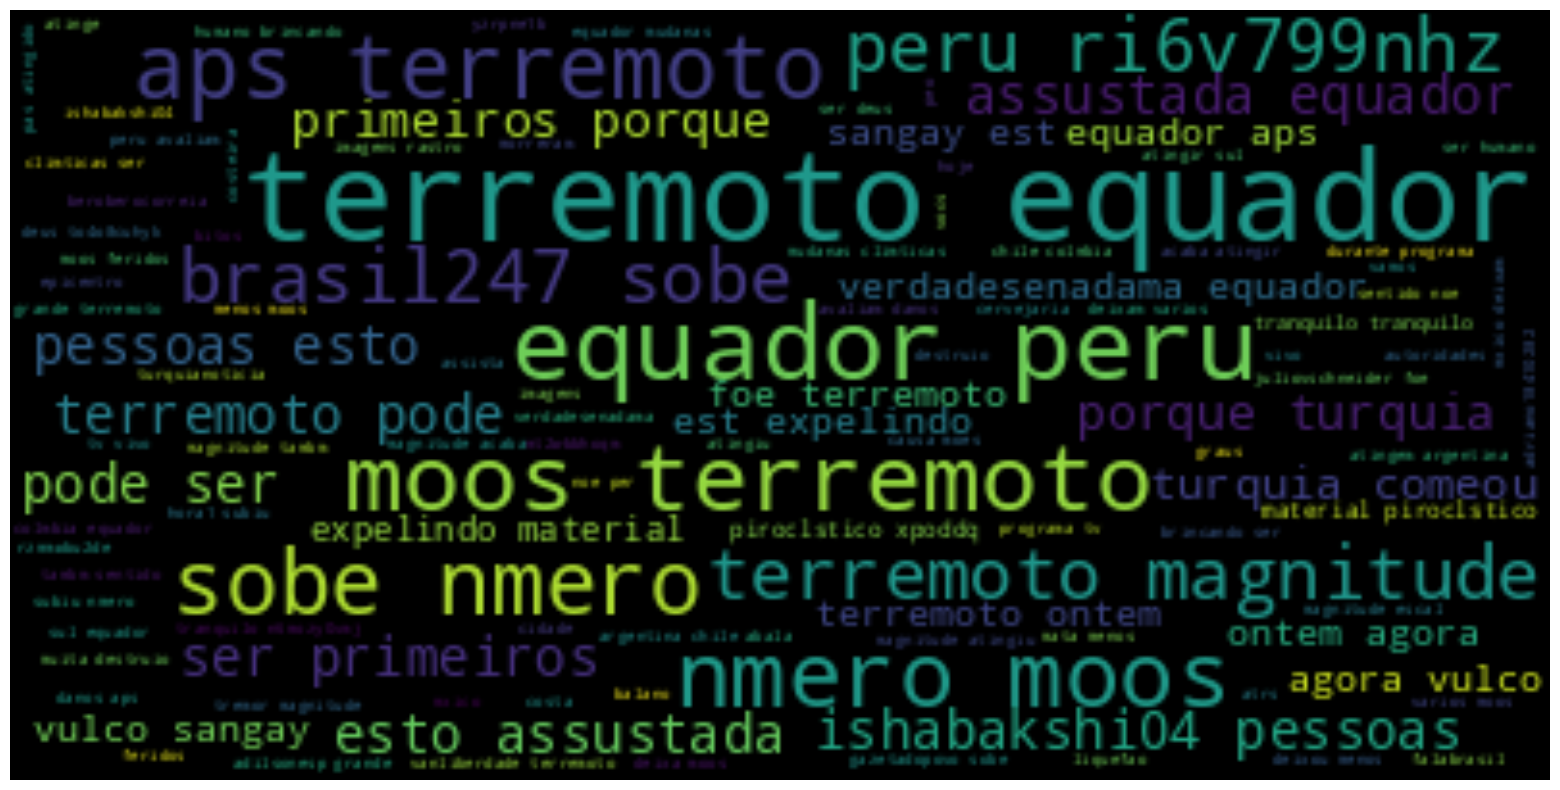

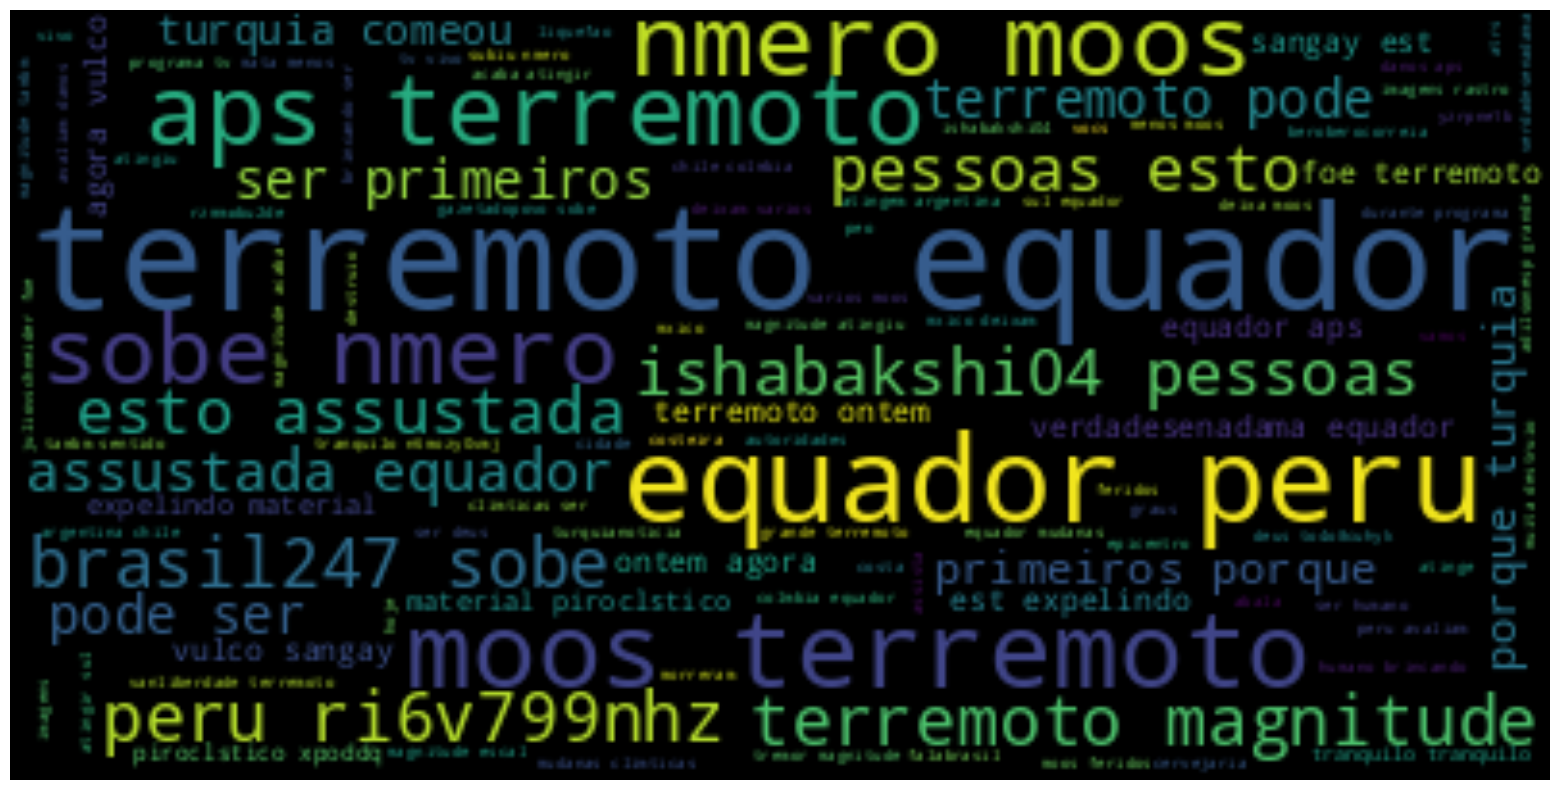

In [25]:
# nuvem de palavras
from wordcloud import WordCloud, STOPWORDS
import re

stext = ""
for tweet in result:
    if 'text' in tweet:
        stext = stext + tweet['text'] + ' '
        
stext = stext.lower() # colocar para minúsculas

# retirando pontuações e outros caracteres não relevantes
stext = "".join([i for i in stext if ord(i)<128])
stext = stext.replace("http://","")
stext = stext.replace("https://","")
stext = stext.replace("https","")
stext = stext.replace(",","")
stext = stext.replace(".","")
stext = stext.replace("?","")
stext = stext.replace("!","")
stext = stext.replace("#","")
stext = stext.replace("@","")
stext = stext.replace("'","")
stext = stext.replace("-","")
stext = stext.replace("3","")
stext = stext.replace("&amp;","")
stext = stext.replace("|","")
stext = stext.replace("tco","")
stext = stext.replace("rt","")



# retirando as stopwords dos tweets
for word in stop_words:
    my_regex = r"\b(?=\w)" + re.escape(word) + r"\b(?!\w)"
    stext = re.sub(my_regex,"" ,stext)

print(len(stext))


# Generate a word cloud image
wordcloud = WordCloud().generate(stext)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(stext)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Estatistica de contagem de palavras

In [26]:
words = stext.split()

In [27]:
from collections import Counter

c = Counter(words)
#print (c.most_common()[:30])
most_common = c.most_common()[:40]

for i in most_common:
    print (i[0])
#for item in words:  #[words, screen_names, hashtags]:
#    c = Counter(item)
#    print (c.most_common()[:20]) # top 10
#    print 

terremoto
equador
moos
peru
15
nmero
magnitude
aps
ser
sobe
pessoas
ishabakshi04:
/ri6v799nhz
verdadesenadama:
brasil247:
tranquilo
esto
assustada
pode
primeiros
porque
turquia
comeou
71
agora
foe
ontem
feridos
68
vulco
sangay
est
expelindo
material
piroclstico
/xpoddq
menos
69
atingiu
vivo


In [28]:
for i in range(15):
    print (c.popitem())

('sbtbrasil', 1)
('/lltu6qwlt7', 1)
('notcia', 1)
('detalhes', 1)
('ver', 1)
('link', 1)
('clique', 1)
('/vpsmvzi7nu', 1)
('/5haocwel4q', 1)
('notcias', 1)
('vi', 1)
('cedo', 1)
('notebook', 1)
('consear', 1)
('tentando', 1)


## colocando as palavras e suas frequencias do twitter num dataframe

In [29]:
import pandas as pd
df = pd.DataFrame(([word, freq] for word, freq in most_common), columns=['Word', 'Frequency'])
df[:25]

,Word,Frequency
0,terremoto,193
1,equador,192
2,moos,61
3,peru,51
4,15,44
5,nmero,40
6,magnitude,35
7,aps,35
8,ser,35
9,sobe,34


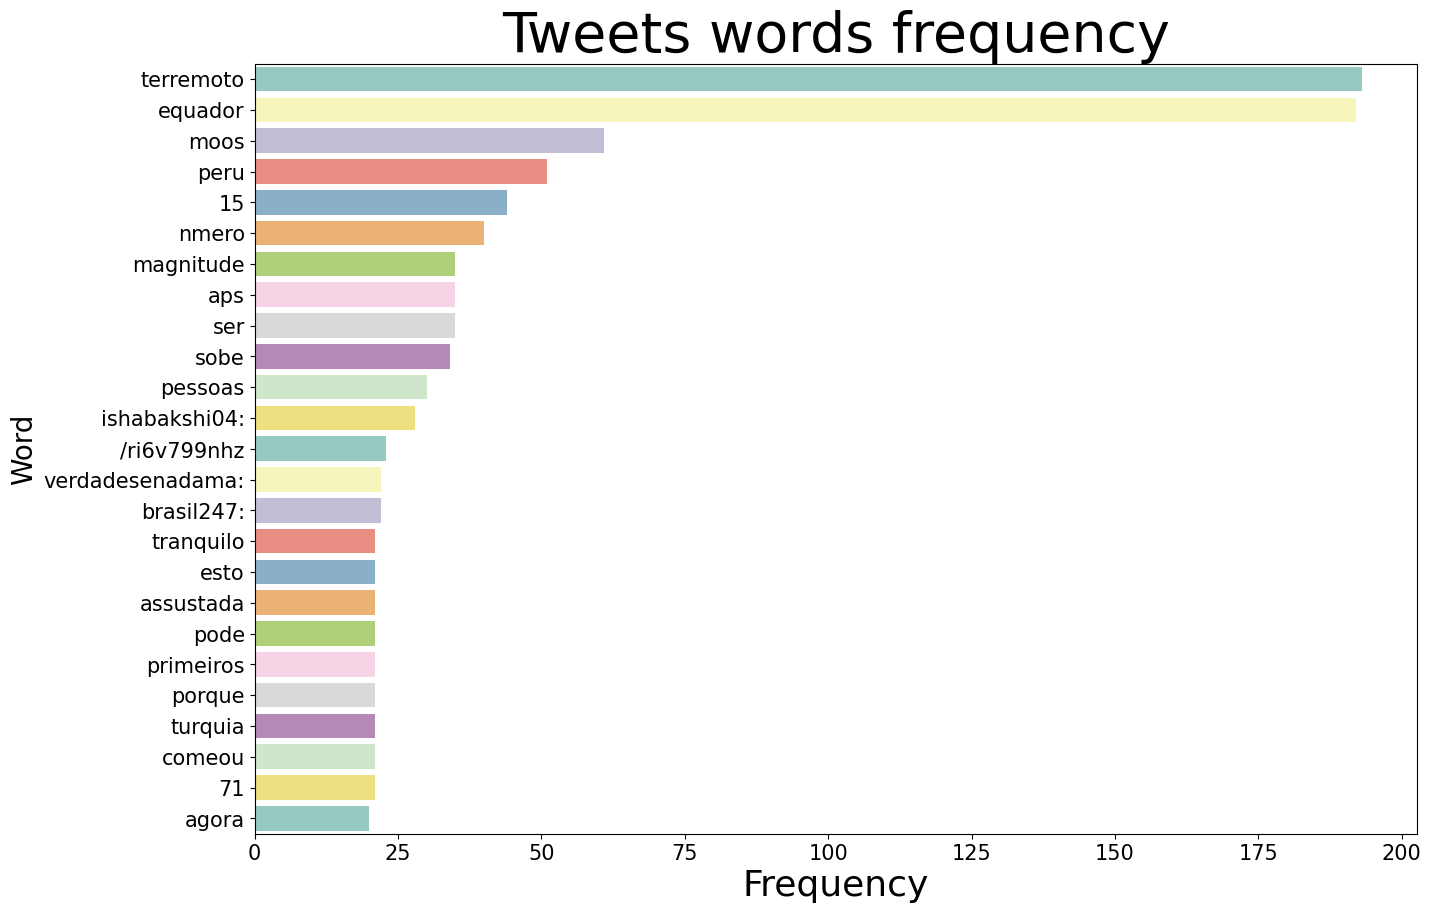

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='Word', x = 'Frequency', data=df2, palette="Set3" )
#sns.despine()
ax.set(xlabel='Tweets words frequency', ylabel='Word')
#ax.set(xticks=range(1, 9), xticklabels=list([10,20,30,40,50,60,70,80,90]))

#ax.set(xticklabels=list(range(0,90,10)))
#plt.figure(figsize=(20,10))

ax.axes.set_title("Tweets words frequency",fontsize=40)
ax.set_xlabel("Frequency",fontsize=26)
ax.set_ylabel("Word",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## achar os países de onde foram gerados os tweets

In [31]:
place = []
results = result.copy()
for result in results:
    if 'place'in result and result['place']:
        place.append(result['place']['country'])
place = set(place)
print(len(place) )
print(place)

1
{'Brazil'}


In [32]:
# cidades
place = []
for result in results:
    if 'user'  in result:
        place.append(result['user']['location'])
location = set(place)
len(location)

91

In [33]:
for i in range(15):
    print(location.pop())


Caucaia, Brasil
MANAUS
Tokyo
Porto Alegre, RS
United Arab Emirates
Itacaré, Brasil
São Paulo, Brasil
Manaus
Rolândia, Brasil
Belo Horizonte, Brasil
Califórnia, USA
Salvador
Rio de Janeiro, Brasil
Brasil 


## contar a ocorrencia de cada cidade

In [34]:
from collections import Counter

c = Counter(location)
#print(c)
cidades = c.items()

## colocando as cidades, frequencia num dataframe e salvando no excel

In [35]:
import pandas as pd
df = pd.DataFrame(([cidade, freq] for cidade, freq in cidades), columns=['city', 'frequency'])

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('cidades.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()
df[:15]

/var/folders/wm/w4f0z08s2jn7bhy010p8gtz40000gn/T/ipykernel_69879/1811925307.py:11: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


,city,frequency
0,"Texas, USA",1
1,Rio dos Cedros-SC,1
2,Sta Cruz doC/PE-João Pessoa/PB,1
3,Esperando TouchStarved,1
4,Avaré-S.P,1
5,"Orocó, Pernambuco, Brasil",1
6,Rio Branco-Acre,1
7,Teixeira - PB - Brasil,1
8,"Parnamirim, Brasil",1
9,"Minas Gerais, Brasil",1


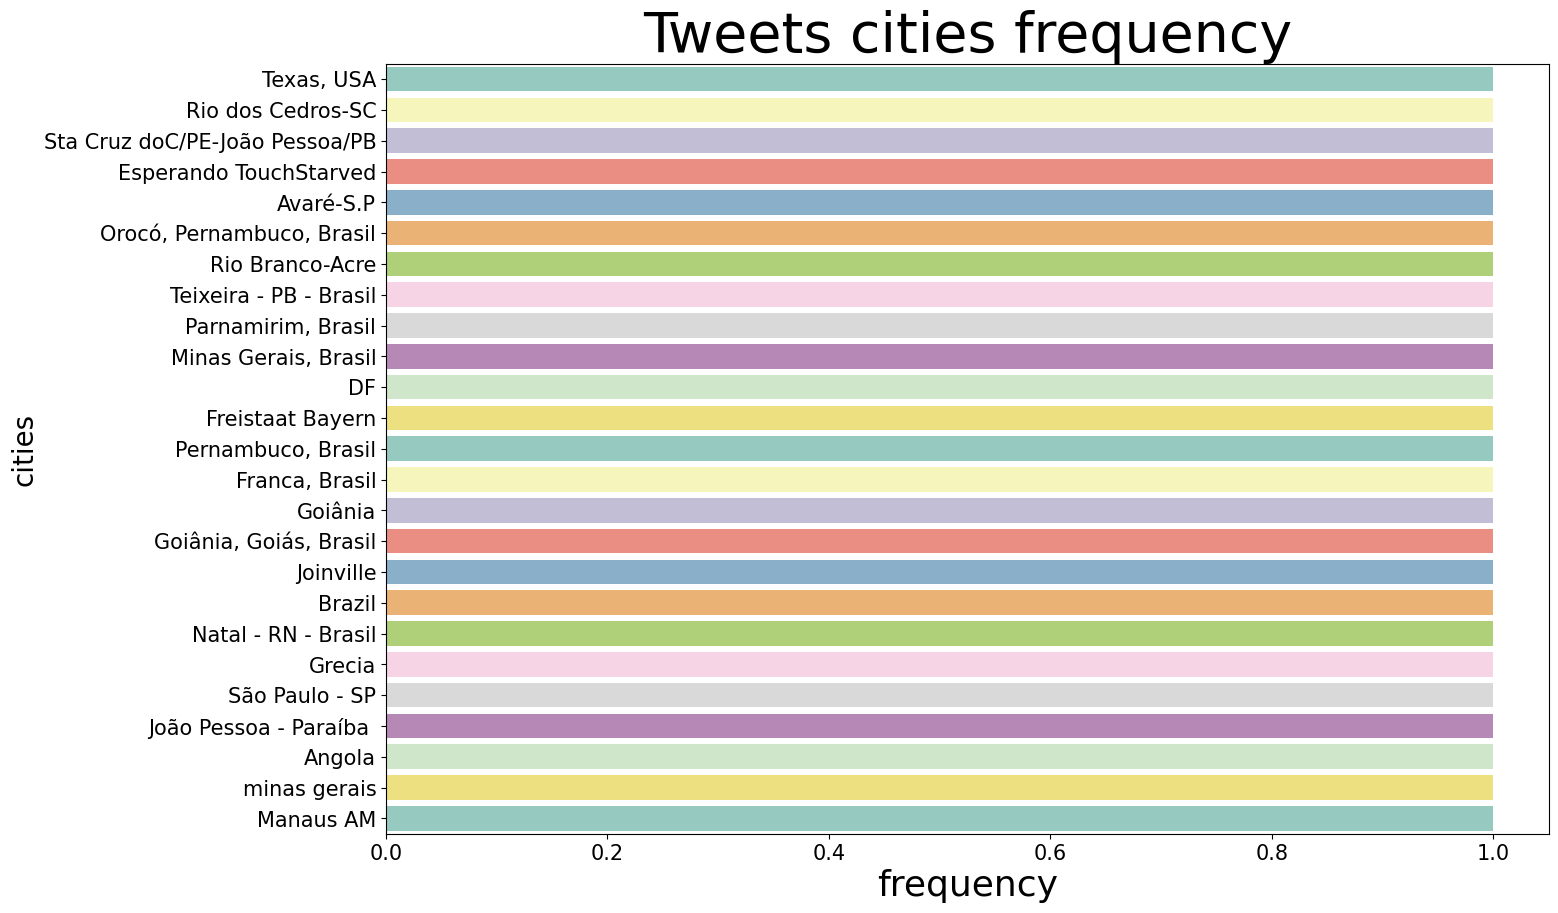

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='city', x = 'frequency', data=df2, palette="Set3" )
ax.set(xlabel='Tweets cities frequency', ylabel='cities')
ax.axes.set_title("Tweets cities frequency",fontsize=40)
ax.set_xlabel("frequency",fontsize=26)
ax.set_ylabel("cities",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## Capturar tweets com coodenadas de lat, long para cidade

In [37]:
def captura_tweets_com_coordenadas(tweets):
    tweets_com_coordenadas = []
    for tweet in tweets:
        if tweet['place'] is not None:
            tweets_com_coordenadas.append(tweet)
    return (tweets_com_coordenadas)

In [38]:
tweets_com_coordenadas = captura_tweets_com_coordenadas(results)
print(len(tweets_com_coordenadas))

1


In [39]:
len(tweets_com_coordenadas)/len(results) * 100

0.5

In [40]:
tweets_com_coordenadas[0]['place']['bounding_box']

{'type': 'Polygon',
 'coordinates': [[[-49.5664051, -26.7733824],
   [-49.2144275, -26.7733824],
   [-49.2144275, -26.4884841],
   [-49.5664051, -26.4884841]]]}

In [41]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates']

[[[-49.5664051, -26.7733824],
  [-49.2144275, -26.7733824],
  [-49.2144275, -26.4884841],
  [-49.5664051, -26.4884841]]]

In [42]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates'][0][0]

[-49.5664051, -26.7733824]

In [43]:
def captura_coordenadas(tweets):
    coordenadas = []
    for tweet in tweets:
        coord = tweet['place']['bounding_box']['coordinates'][0][0]
        coordenadas.append(coord)
    return coordenadas

In [44]:
tweets_coordenadasXY = captura_coordenadas(tweets_com_coordenadas)
tweets_coordenadasXY[:5]

[[-49.5664051, -26.7733824]]

In [45]:
len(tweets_com_coordenadas)

1

In [46]:
latitudes_tweets =  [ y for x,y in tweets_coordenadasXY]
longitudes_tweets =  [ x for x,y in tweets_coordenadasXY]

In [47]:
coordenadas_distintas = set(latitudes_tweets)
len(coordenadas_distintas)

1

In [48]:
print(list(latitudes_tweets[:15]))

[-26.7733824]


In [49]:
print(list(longitudes_tweets[:15]))

[-49.5664051]


In [50]:
import pandas as pd
df10 = pd.DataFrame({'latitude': latitudes_tweets, 'longitude':longitudes_tweets })
df10.head()                   

,latitude,longitude
0,-26.773382,-49.566405


In [51]:
len(df10)

1

In [52]:
df11 = df10.drop_duplicates()
df11 = df11.reset_index(drop=True)
len(df11)

1

In [53]:
df11.to_csv('coordenadas-tweets.csv', index=False)

In [54]:
import pandas as pd
df11 = pd.read_csv('coordenadas-tweets.csv')
df11.head()

,latitude,longitude
0,-26.773382,-49.566405


In [55]:
for i in range(len(df11)):
    #print(i)
    row = df11.loc[i]
    #print(row)
    print('latitude:', row['latitude'], ', longitude:', row['longitude'] )

latitude: -26.7733824 , longitude: -49.5664051


In [56]:
print(list(latitudes_tweets[:10]))

[-26.7733824]


In [57]:
print(list(longitudes_tweets[:10]))

[-49.5664051]


## ler coordenadas de um arquivo

In [58]:
df10 = pd.read_csv('coordenadas-tweets-Novembro-2019.csv')
df10.head()

,latitude,longitude
0,40.802734,28.632104
1,19.826460,-84.952008


In [59]:
df12 = df10.copy()
df12.head()
df12 = df12.dropna()
len(df12)
df12.head()

,latitude,longitude
0,40.802734,28.632104
1,19.826460,-84.952008


## remover tuplas duplicadas

In [60]:
df13 = df12.drop_duplicates()
df13 = df13.reset_index(drop=True)
len(df13)

2

# Georeferenciar os tweets no mapa mundi

In [62]:
#!pip install -q folium

In [63]:
tweets_coordenadasXY

[[-49.5664051, -26.7733824]]

In [64]:
import folium
from folium.utilities import write_png

mapit = folium.Map(location=[30, 0], zoom_start=2)
for coord in tweets_coordenadasXY:
    folium.CircleMarker( location=[ coord[1], coord[0] ], radius=2).add_to( mapit ) 
                    # color='#0080bb', fill_color='#0080bb'


folium.Map.save(mapit, "index.html")


mapit

# twitter trends - assuntos mais comentados do momento

In [65]:
import json
import twitter

# Acessar os tends da localidade
#http://woeid.rosselliot.co.nz/


def twitter_trends(twitter_api, woe_id):
    # Prefix ID with the underscore for query string parameterization.
    # Without the underscore, the twitter package appends the ID value
    # to the URL itself as a special-case keyword argument.
    return twitter_api.trends.place(_id=woe_id)

# Sample usage

twitter_api = oauth_login()

# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/ for details on
# Yahoo! Where On Earth ID

WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
#print json.dumps(world_trends, indent=1)

US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
#print (json.dumps(us_trends, indent=1))
#us_trends[0]

#for trend in us_trends:
#    print (trend['as_of']['name'])

In [66]:
def find_trends(country_trends):
    trends = country_trends[0]['trends']
    for trend in trends:
        print (trend['name'])

In [67]:
from datetime import datetime
WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
print ("topicos mais comentados: Mundo", datetime.now())
find_trends(world_trends)

topicos mais comentados: Mundo 2023-03-20 18:38:35.250047
#LaIslaDeLasTentaciones9
#LaleyiAklayamazsınTRT
LIBERTAD Y ORDEN
Mehmet Şimşek
#AmorPerfeito
#MAPR
#صدیق_جان_کو_رہا_کرو
Orietta
Spring
Carl Sagan
Kaduna
Hilmi
Celal Şengör
Amanda Bynes
Kevin Harlan
Alfonso
Victoria Alonso
Natacha Jaitt
Marcelo Corazza
Shanks
Costello
Iraq
Fatih Erbakan
Başınız
Yvonne
JOELMA NO TVZ POCAH
Jim Jordan
Dalton Schultz
Kandi
Bryson Tiller
Tamar
Ryan Mason
Marvel Studios
Tareck El Aissami
杉本健勇
きゃりーちゃん
Kübra Par
Tuvalet Terliği
Ofsted
Diablox9
春分の日
St. John
Borne
万能ストライカー
Bragg
Colby
HDP Gençliği
Rick Pitino
足元の技術
Eibar


In [68]:
US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
print ("topicos mais comentados: USA", datetime.now())
find_trends(us_trends)

topicos mais comentados: USA 2023-03-20 18:38:45.020779
#MAGABudgetDisaster
Costello
Amanda Bynes
Kevin Harlan
Spring
#Arrestmas
Bryson Tiller
#Nowruz
Dalton Schultz
Tamar
Kandi
Jim Jordan
Ted Lasso
#ONEPIECE1079
St. John
Singletary
Woke Wall Street
Iraq
Rick Pitino
Larry June
#IReallyWantToBringBack
Barron
Dan Schneider
Persian
Goodell
Trent Crimm
Gym Jordan
Dameon Pierce
Simon
Victoria Alonso
Bragg
Georgetown
Franklin Graham
Jason Sudeikis
Marvel Studios
Jim Acosta
Uncle Buck
Aries
Uvalde
Shanks
Harambe
Providence
Nick Fuentes
Feliciano
OJ Howard
Ted Lieu
Fauci
Rita
Ed Cooley
Happy New Year


In [69]:
BR_WOE_ID = 23424768
br_trends = twitter_trends(twitter_api, BR_WOE_ID)
print ("topicos mais comentados: Brasil", datetime.now())
find_trends(br_trends)

topicos mais comentados: Brasil 2023-03-20 18:38:45.681471
#AmorPerfeito
JOELMA NO TVZ POCAH
frank ocean
#FofocalizandoNoSBT
Shanks
Riquelme
#OReidoGado
Mais Médicos
Adidas
#ONEPIECE1079
Marê
Heart Attack
Kendrick
Camila Queiroz
Davy Jones
#ADona070
Áries
Willian Bigode
Ademir
Max Martin
Umbro
Sartre
Baphomet
Fernanda Gentil
Victoria Alonso
Barba Negra
Sheron
JULIA NA CADEIA
Campos Neto
Shoppe
Meninos da Vila
Andreas
Sampaoli
Athletico
Deyverson
Pepa
Barolo
Neto e Denilson
Brad Pitt
Cuba
João Ricardo
Outono
Léo Dias
Marvel Studios
Petraglia
Montanha
Bolsa Família
Jeová
Diggo
aliexpress


In [70]:
TM_WOE_ID = 32566
tm_trends = twitter_trends(twitter_api, TM_WOE_ID)
print ("topicos mais comentados: UK")
find_trends(tm_trends)

topicos mais comentados: UK
Shannon
#unforgotten
#Hollyoaks
Antonio Conte
#SeaOfThieves
Network Rail
Saddam
Weds
Bellingham
MySpace
#24hoursinpolicecustody
Ryan Mason
Ofsted
RIP Charlie
Poch
Damon
Bronte
Rupert Murdoch
Florida
The DUP
Banoffee
Ruth Perry
Flora
Enrique
Stormont
Rufus
Reform
Whitney
Gary Anderson
Paratici
Loose Women
Scampton
Goodison
Daniel Levy
Sinn Fein
O'Hara
Tice
Nuno
Ann Widdecombe
Spitting Image
De Zerbi
Milo
Merrin
Wigan Athletic
China and Russia
Zinny
Nicola Sturgeon
Yvonne
Colby


In [71]:
TM_WOE_ID = 455827
tm_trends = twitter_trends(twitter_api, TM_WOE_ID)
print ("topicos mais comentados: São Paulo")
find_trends(tm_trends)

topicos mais comentados: São Paulo
Nobel
#iHeartAwards
Ciro
#AmorPerfeito
JOELMA NO TVZ POCAH
frank ocean
#FofocalizandoNoSBT
Shanks
Riquelme
#OReidoGado
Mais Médicos
Adidas
#ONEPIECE1079
Marê
Heart Attack
Kendrick
Camila Queiroz
Davy Jones
Áries
Willian Bigode
Ademir
Max Martin
Umbro
Sartre
Baphomet
Fernanda Gentil
Victoria Alonso
Barba Negra
Sheron
JULIA NA CADEIA
Campos Neto
Shoppe
Meninos da Vila
Andreas
Sampaoli
Athletico
Deyverson
Pepa
Barolo
Neto e Denilson
Brad Pitt
Cuba
João Ricardo
Outono
Léo Dias
Marvel Studios
Petraglia
Montanha
Bolsa Família
Jeová


# Análise de Sentimentos - Tweets

In [84]:
!pip install -q textblob
#!python -m pip install --pre googletrans

In [82]:
!pip install -q googletrans
#!pip install google_trans_new

In [76]:
#!pip install -q googletrans==4.0.0-rc1

In [86]:
from googletrans import Translator
translator = Translator()

#translator.translate('veritas lux mea', src='la')
translator.translate('oi, tudo bem', src='pt' ) #, src='pt') #, src='pt', dest='en') 

AttributeError: 'NoneType' object has no attribute 'group'

### Testando as polaridades

In [87]:
from textblob import TextBlob as tb
txt = 'bad girl in NY'
analysis = tb(txt)
analysis.sentiment.polarity
analysis.sentiment

Sentiment(polarity=-0.6999999999999998, subjectivity=0.6666666666666666)

In [88]:
txt = 'neutral'
analysis = tb(txt)
analysis.sentiment.polarity

0.0

In [89]:
txt = 'good'
analysis = tb(txt)
analysis.sentiment.polarity

0.7

# polaridade de tweets em ingles e portugues

In [93]:
from textblob import TextBlob as tb #NLP module
import numpy as np #for some calculation. You may want to use your favorite module for this, such as statistics

# polaridade de tweets em ingles e portugues
def polarity_tweets_pais(query):
    from googletrans import Translator
    
    translator = Translator() # google tradutor

    twitter_api = oauth_login()
    numero_iteracoes = 1
    results = []
    for i in range(numero_iteracoes):
        max_results = 500 # 1000
        result = twitter_search(twitter_api, query, max_results=max_results)
        print ('capturando ', len(result),' tweets...')
        #results.append(result)
        results += result

    analysis = None
    pos_polarity = 0
    neutral_polarity = 0
    neg_polarity = 0
    sum_polarity = 0
    print("calculando polaridades...")

    for tweet in results:
        text_tweet = tweet['text']
        
        # retirando caracteres malucos
        text_tweet = "".join([i for i in text_tweet if ord(i)<128])
        
        frase = tb(text_tweet)       
        language = tweet['lang'] #frase.detect_language()
#         if language == 'br' or language == 'pt' :
#             text_en = translator.translate(text_tweet, src='pt').text  
#             analysis = tb(text_en)
#         elif language == 'en':   
#             analysis = frase
#         else:
#             analysis = ""

        analysis = tb(text_tweet)
            
        if analysis != "": 
            if (analysis.sentiment.polarity > 0):
                pos_polarity += 1
            elif (analysis.sentiment.polarity <= 0):
                neg_polarity += 1
            sum_polarity += analysis.sentiment.polarity

    return sum_polarity, pos_polarity, neg_polarity, neutral_polarity

In [94]:
q = 'tesla'

mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
total = pos_polarity + neg_polarity + neutral_polarity 
print('SENTIMENT AVERAGE: ' , mean_polarity/total)
print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100)

capturando  596  tweets...
calculando polaridades...
SENTIMENT AVERAGE:  0.08017222349332244
Positive:  192 32.21476510067114
Negative:  404 67.78523489932886
neutral:  0 0.0


In [95]:
import pandas as pd
df = pd.DataFrame(columns=['name', 'pos', 'negative', 'sentiment_avg'])
queries = [ 'tesla', 'facebook', 'apple', 'xiaomi']

for q in queries:
    mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
    total = pos_polarity + neg_polarity + neutral_polarity 
    print('Query: ', q)
    print('SENTIMENT AVERAGE: ' , mean_polarity/total)
    print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
    print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
    #print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100)
    print('----------------------------------------------')
    
    i = len(df)
    df.loc[i] = [q, pos_polarity, neg_polarity, mean_polarity/total]
df

capturando  596  tweets...
calculando polaridades...
Query:  tesla
SENTIMENT AVERAGE:  0.07589523238537495
Positive:  188 31.543624161073826
Negative:  408 68.45637583892618
----------------------------------------------
capturando  599  tweets...
calculando polaridades...
Query:  facebook
SENTIMENT AVERAGE:  0.05722846939510129
Positive:  141 23.53923205342237
Negative:  458 76.46076794657763
----------------------------------------------
capturando  600  tweets...
calculando polaridades...
Query:  apple
SENTIMENT AVERAGE:  0.033869464680190906
Positive:  124 20.70116861435726
Negative:  475 79.29883138564274
----------------------------------------------
capturando  600  tweets...
calculando polaridades...
Query:  xiaomi
SENTIMENT AVERAGE:  0.04107575757575757
Positive:  105 17.5
Negative:  495 82.5
----------------------------------------------


,name,pos,negative,sentiment_avg
0,tesla,188,408,0.075895
1,facebook,141,458,0.057228
2,apple,124,475,0.033869
3,xiaomi,105,495,0.041076


In [96]:
df["%pos"] = df.pos / (df.pos + df.negative)
df["%neg"] = df.negative / (df.pos + df.negative)
df["%pos"] = df["%pos"].apply(lambda x: int(round(x,1) * 100))
df["%neg"] = df["%neg"].apply(lambda x: int(round(x,1) * 100))
df.loc[:, ['name', "%pos", "%neg", 'sentiment_avg' ]]

,name,%pos,%neg,sentiment_avg
0,tesla,30,70,0.075895
1,facebook,20,80,0.057228
2,apple,20,80,0.033869
3,xiaomi,20,80,0.041076


### gravando os dados do dataframe num arquivo .csv

In [97]:
from datetime import datetime
data_agora = str(datetime.now())
df.to_csv("sentimentos-"+ data_agora +".csv")

In [98]:
df.loc[:, ['name', "%pos", "%neg" ]]

,name,%pos,%neg
0,tesla,30,70
1,facebook,20,80
2,apple,20,80
3,xiaomi,20,80
